In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config
from BondingCurveNexus.sys_class import NexusSystem
from scipy.stats import poisson, lognorm, norm
from random import shuffle

In [13]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)
eth_price_usd = float(eth_client.get_eth_last_price()['ethusd'])
eth_price_usd

1861.29

In [3]:
supply_url = 'https://api.coingecko.com/api/v3/coins/wrapped-nxm'
wnxm_supply_now = requests.get(supply_url).json()['market_data']['total_supply']
wnxm_supply_now

2820876.71761567

# Dutch Auction Modelling

## Reverse Dutch Auction Mechanism - Below Book

At launch, exit price = wnxm price (or slightly below)

2 Mechanisms:
1. Uniswap v2 Curve to push price down when sales happen
2. Slow increase in system price over time

Ceiling at book value - we don't want to allow people to sell for more than BV.

Incentive not to wait longer - some people may end up exiting in front of you and drive down the price.
In the long term should tend towards book value as liquidity at lower levels is drained.

### Initial Liquidity

In [7]:
free_capital_perc = 0.5
liq_alloc_perc = 0.5
free_capital = system.cap_pool * free_capital_perc
opening_liquidity_eth = liq_alloc_perc * free_capital

### wNXM Liquidity in Open Market

Obtained from https://www.coingecko.com/en/coins/wrapped-nxm#markets, summed +2% and -2% depth across all exchanges & averaged the two

In [11]:
wnxm_liq_2perc_usd = 236_260

In [14]:
wnxm_liq_2perc_eth = wnxm_liq_2perc_usd/eth_price_usd
wnxm_liq_2perc_eth

126.93347087235198

### Uniswap v2 OOP Class

In [37]:
# Create class with initial liquidity parameters

class UniPool:
    # initial parameters
    def __init__(self):
        # initial wNXM price, wNXM and NXM supply
        self.wnxm_price = NexusSystem().wnxm_price
        self.nxm_supply = NexusSystem().nxm_supply
        self.wnxm_supply = wnxm_supply_now
        # set initial ETH liquidity
        self.liquidity_eth = opening_liquidity_eth
        # set initial NXM liquidity
        self.liquidity_nxm = self.liquidity_eth / NexusSystem().wnxm_price
        # set intial invariant 
        self.invariant = self.liquidity_eth * self.liquidity_nxm
        # set cumulative parameters to 0
        self.eth_sold = 0
        self.nxm_burned = 0
    
    # system nxm price expressed in ETH
    def nxm_price(self):
        return self.liquidity_eth / self.liquidity_nxm
    
    # one sale of n_nxm NXM
    def sale(self, n_nxm):
        # add sold NXM to pool
        self.liquidity_nxm += n_nxm
        self.nxm_supply -= n_nxm
        # capture original ETH in pool and update to new value
        new_eth = self.invariant / self.liquidity_nxm
        # add ETH removed amount to cumulative total 
        self.eth_sold += self.liquidity_eth - new_eth
        self.liquidity_eth = new_eth
        
    def ratchet(self, n_nxm):
        self.liquidity_nxm -= n_nxm
        self.invariant = self.liquidity_eth * self.liquidity_nxm

In [38]:
below_bv_ratchet_perc = 0.01

In [39]:
sim = UniPool()
print(sim.nxm_price())
sim.ratchet(sim.liquidity_nxm*below_bv_ratchet_perc)
print(sim.nxm_price())

0.00949828
0.009594222222222223


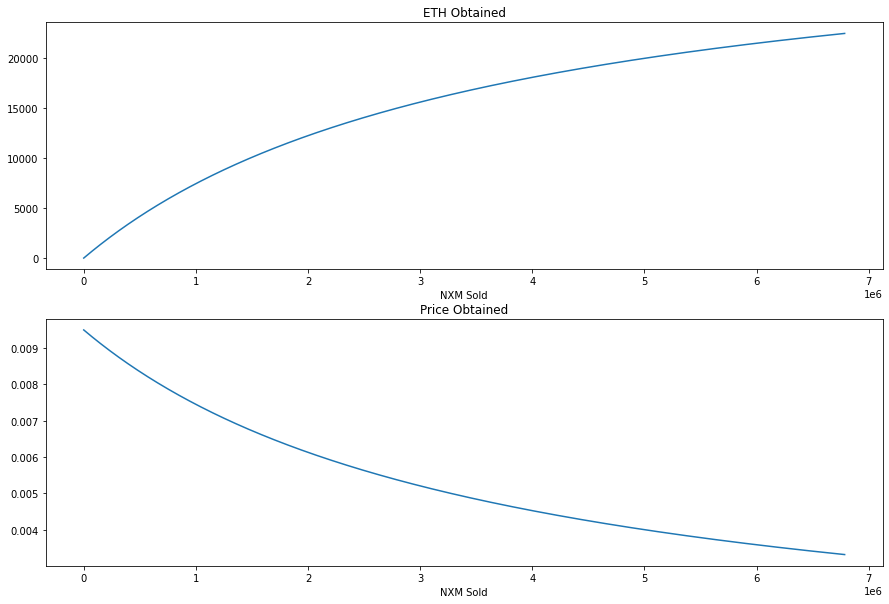

In [49]:
# sale size vs ETH and Price obtained 
sale_sizes = np.linspace(100, NexusSystem().nxm_supply, 1000)
eth_obtained = []
nxm_prices_obtained = []

for n_nxm in sale_sizes:
    sim = UniPool()
    sim.sale(n_nxm)
    eth_obtained.append(sim.eth_sold)
    nxm_prices_obtained.append(sim.eth_sold / n_nxm)
    
fig, axs = plt.subplots(2, 1, figsize=(15,10))
axs[0].plot(sale_sizes, eth_sold)
axs[0].set_title('ETH Obtained')
axs[0].set_xlabel('NXM Sold')
axs[1].plot(sale_sizes, nxm_prices_obtained)
axs[1].set_title('Price Obtained')
axs[1].set_xlabel('NXM Sold');

In [40]:
sim = UniPool()
print(sim.liquidity_nxm)
print(sim.liquidity_eth)
sim.sale(10_000)
print(sim.liquidity_nxm)
print(sim.liquidity_eth)

3636342.579919733
34539.0
3646342.579919733
34444.27768786673


In [50]:
sim.eth_sold

22488.06023105508